# 26-3-Evaluating Clusters 
- k-means algorithm for clustering
- k-means is an iterative algorithm that takes the number of clusters (k) as given and groups the observations into k clusters based on the nearest mean of each cluster
- Pre-req
    * Cluster number is k: we provide the value of k to k-means, we need to determine the best value. we need to run k-means with several k values and choose the one that makes most sense to us.
    * Clusters are isotropic: meaning that they are uniform in all directions and the edges curve outward. 
    * Similar variance K-means also assumes all clusters have similar variance.
    
- Similar variance K-means also assumes all clusters have similar variance.
- The initial selection of centroids is important. Try the algorithm a few times with different starting centroids. The sklearn implementation has a nifty kmeans++ option (which is also the default) for initializing centroids that are distant from each other, and this approach is less likely to result in a flawed solution. Moreover, by default, sklearn runs the algorithm 10 times (we can set it to a different value using n_init parameter) with different centroid seeds and selects the best output in terms of inertia.
-  standardizing each variable is a common practice before applying k-means.

## Assignment

Get the silhouette coefficient of the two cluster k-means solution. You'll notice that the silhouette coefficient will turn out to be greater than the one above where cluster number is three. We know that the Iris dataset consists of three different clusters. How do you explain that the silhouette score of the solution with the number of clusters being equal to the correct number of classes is lower than the one where the number of clusters is different from the correct number of classes?



In [5]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import datasets, metrics

In [6]:
# Loading the data from Sklearn's datasets
iris = datasets.load_iris()
X = iris.data
y = iris.target

# Standarizing the features
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

In [7]:
# Computing the first principal components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_std)

In [8]:
# Split the data into four equally-sized samples. First we break it in half:
X_half1, X_half2, X_pcahalf1, X_pcahalf2 = train_test_split(
    X_std,
    X_pca,
    test_size=0.5,
    random_state=13579)

In [9]:
# Data frame to store features and predicted cluster memberships.
ypred = pd.DataFrame()

# Pass a list of tuples and a counter that increments each time we go
# through the loop. The tuples are the data to be used by k-means,
# and the PCA-derived features for graphing. We use k-means to fit a
# model to the data, then store the predicted values and the two-feature
# PCA solution in the data frame.
for counter, data in enumerate([
    (X_half1, X_pcahalf1),
    (X_half2, X_pcahalf2)]):
    
    # Put the features into ypred.
    ypred['pca_f1' + '_sample' + str(counter)] = data[1][:, 0]
    ypred['pca_f2' + '_sample' + str(counter)] = data[1][:, 1]
    
    # Generate cluster predictions and store them for clusters 2 to 4.
    for nclust in range(2, 5):
        pred = KMeans(n_clusters=nclust, random_state=123).fit_predict(data[counter])
        ypred['clust' + str(nclust) + '_sample' + str(counter)] = pred

Now, we can visualize the results. We graph the clustering results for each of the subsamples, first for the two-cluster solution and then for three- and four-cluster ones.

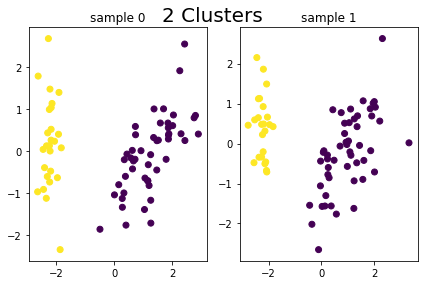

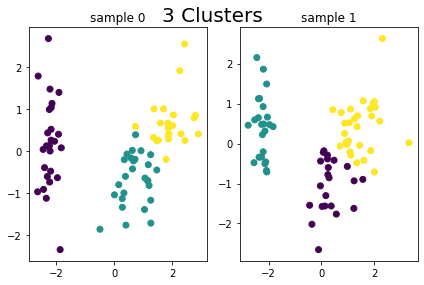

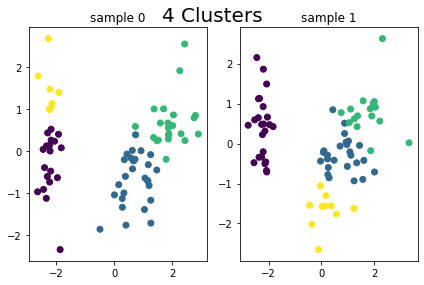

In [10]:
# For each  number of clusters, plot the clusters using the
# pca features for each sample.
for cluster in range(2, 5):
    
    # Make a grid of subplots.
    f, axarr = plt.subplots(1, 2)
    
    # Make a plot for each sample.
    for i in range(2):
        
        # PCA-created features.
        x_sub = ypred['pca_f1_sample{}'.format(i)]
        y_sub = ypred['pca_f2_sample{}'.format(i)]
        
        # Cluster assignments.
        c = ypred['clust{}_sample{}'.format(cluster, i)]
        
        # Assign the subplot to its place on the grid.
        axarr[i].scatter(x_sub, y_sub, c=c)
        axarr[i].set_title('sample {}'.format(i))
    
    # Space out the plots so that the headings don't overlap axis values.
    plt.suptitle('{} Clusters'.format(cluster), fontsize=20)
    plt.tight_layout()
    plt.show()
    print('\n')

### Different ways to evaluate clusters
* When we have existing labels: contingency tables, RI, and ARI
* When we don't have existing labels: similarity

In [11]:
### contingency tables
# Get predicted clusters.
full_pred = KMeans(n_clusters=3, random_state=123).fit_predict(X_std)

pd.crosstab(y, full_pred) 

col_0,0,1,2
row_0,,,
0,50,0,0
1,0,39,11
2,0,14,36


In [12]:
### Renaming the table and printing the above crosstab
full_pred = np.array([0 if x == 1 else 1 if x==0 else 2 for x in full_pred])

pd.crosstab(y, full_pred) 

col_0,0,1,2
row_0,,,
0,0,50,0
1,39,0,11
2,14,0,36


 this basic contingency table solution fails to capture one of the most important things about clustering – that it not only tells us about cluster memberships of individual datapoints, but also about the relationships between datapoint pairs. To do that, let's talk about Rand Index:

In [13]:
def rand_index_score(grount_truths, predictions):
    tp_plus_fp = scipy.special.comb(np.bincount(grount_truths), 2).sum()
    tp_plus_fn = scipy.special.comb(np.bincount(grount_truths), 2).sum()
    A = np.c_[(grount_truths, predictions)]
    tp = sum(scipy.special.comb(np.bincount(A[A[:, 0] == i, 1]), 2).sum()
             for i in set(grount_truths))
    fp = tp_plus_fp - tp
    fn = tp_plus_fn - tp
    tn = scipy.special.comb(len(A), 2) - tp - fp - fn
    return (tp + tn) / (tp + fp + fn + tn)

In [14]:
rand_index_score(y, full_pred)

0.8330201342281879

While RI is nice because it can also be interpreted as the probability that the ground truth and the new solution will agree for any pair, it fails to account for the effect of chance. If we just assigned datapoints to clusters at random (the same number and size of clusters), we'd get an RI considerably higher than 0.

In [15]:
###Adjusted Rand Index (ARI)
metrics.adjusted_rand_score(y, full_pred)

0.6201351808870379

This tells us that our k-means clustering solution is closer to perfect than to random. Yet, there's still room for improvement. Perhaps a different algorithm would do better.
Note: ARI can be used effectively on all clustering algorithm types, so it is great for comparing different algorithm solutions to one another.

In [16]:
### Similarity
labels = KMeans(n_clusters=3, random_state=123).fit_predict(X_std)
print(metrics.silhouette_score(X_std, labels, metric='euclidean'))

0.45994823920518635


It appears that our three-cluster solution produces clusters of datapoints that are closer to other datapoints in the cluster than they are to datapoints in the other clusters. This is good.